In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB,ComplementNB,MultinomialNB,BernoulliNB,CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Loading the Data

In [2]:
store_info = pd.read_csv("/kaggle/input/data-storm-4/Store-info.csv")
transactions=pd.read_csv("/kaggle/input/data-storm-4/Historical-transaction-data.csv")
testing = pd.read_csv("/kaggle/input/data-storm-4/Testing-data.csv")
# transactions["transaction_date"]
# len(transactions[transactions["shop_id"] =="SHOP008"]["item_description"].unique())
# transactions = transactions[~transactions["invoice_id"].isnull()]
JUICES = {name:index for index,name in enumerate(dict(transactions["item_description"].value_counts()).keys())}
print(JUICES)

def create_juice_vector(series):
    juice_series=series["item_description"].value_counts()
    ar = np.zeros(len(JUICES),int)
    for a,b in dict(juice_series).items():
#         print(a)
        ar[JUICES[a]]=b
    return ar





{'GINGER BEER 1.5L': 0, 'CREAM SODA 1.5L': 1, 'CREAM SODA 500ML': 2, 'GINGER BEER 1L': 3, 'ORANGE BARLEY 1.5L': 4, 'NECTO 1.5L': 5, 'SODA 500ML': 6, 'BOTTLED DRINKING WATER 500ML': 7, 'SODA PET 1.5L': 8, 'FIT O ORANGE 1L': 9, 'LEMONADE 1.5L': 10, 'SODA 1L': 11, 'TONIC PET 500ML': 12, 'GINGER BEER 500ML': 13, 'CREAM SODA APPLE POP 1L': 14, 'FIT O ORANGE 200ML': 15, 'BOTTLED DRINKING WATER 1.5L': 16, 'ORANGE CRUSH 1.5L': 17, 'FIT O MIXED FRUIT 200ML': 18, 'FIT O MIXED FRUIT 1L': 19, 'FIT O MANGO 1L': 20, 'LEMONADE 500ML': 21, 'FIT O MANGO 200ML': 22, 'GINGER BEER SUGAR FREE 500ML': 23, 'DRY GINGER ALE PET 500ML': 24, 'STRAWBERRY MILK 180ML': 25, 'ORANGE CRUSH 500ML': 26, 'TWISTEE APPLE 1L': 27, 'NECTO 500ML': 28, 'CREAM SODA 1L': 29, 'GINGER BEER 400ML': 30, 'KIK COLA 1L': 31, 'LEMONADE 1L': 32, 'ORANGE CRUSH 1L': 33, 'NECTO 1L': 34, 'LIME CRUSH JUICE 1L': 35, 'CHOCOLATE MILK 180ML': 36}


In [3]:
## covert data to integer
def stringToDate(dstr):
    dateStringList = dstr.split("T")
    dateExtracted = dateStringList[0]
    yearMonDay = dateExtracted.split("-")
    mon = int(yearMonDay[1])
    date = int(yearMonDay[2])
    if mon == 10:
        return date-15
    elif mon == 11:
        return date+16
    return date+46
transactions["date"] = transactions["transaction_date"].map(str).map(stringToDate)
transactions.head()
DATE_LEN = 62
def create_time_vector(series):
    time_series = series["date"].value_counts()
    ar = np.zeros(DATE_LEN)
    for a,b in dict(time_series).items():
        ar[a] = b
    return ar
create_time_vector(transactions[transactions["shop_id"]=="SHOP007"])

array([ 75.,  60.,  51.,  76.,  58.,  81.,  69.,  77.,  93.,  50.,  51.,
        45.,  61.,  58.,  41.,  55.,  43.,  24.,  52.,  32.,  37.,  27.,
        42.,  31.,  27.,  35.,  39.,  43.,  61.,  52.,  58.,  41.,  21.,
        39.,  65.,  61.,  73.,  50.,  59.,  34.,  28.,  34., 101.,  85.,
        76.,  83.,  70.,  89.,  72.,  75.,  52.,  74.,  58.,  80.,  60.,
        93.,  76., 104., 109.,  54.,  89.,  53.])

# Basic Feature Engineering and Seperating Training and Testing

In [4]:
def compute_combined_data():
    transactions["income"] = transactions["item_price"]*transactions["quantity_sold"]
    transactions["weighted_income"] = transactions["income"]*(transactions["date"]/max(transactions["date"])+1)
    transactions["weighted_quantity"] = transactions["quantity_sold"]*(transactions["date"]/max(transactions["date"])+1)

    combined_data = store_info[['shop_id', 'shop_area_sq_ft']].copy()
    combined_data['income']= combined_data["shop_id"].map(
        lambda key:transactions[transactions["shop_id"]==key]["income"].sum()
    )
    combined_data["quantity"]=combined_data["shop_id"].map(
        lambda key:transactions[transactions["shop_id"]==key]["quantity_sold"].sum()
    )
    combined_data["product_diversity"]=combined_data["shop_id"].map(
        lambda key:len(transactions[transactions["shop_id"] ==key]["item_description"].unique())
    )
    combined_data["customer_diversity"]=combined_data["shop_id"].map(
        lambda key:len(transactions[transactions["shop_id"] ==key]["customer_id"].unique())
    )
    combined_data["income_growth"]=combined_data["shop_id"].map(
        lambda key:transactions[transactions["shop_id"] ==key]["weighted_income"].sum()
    )
    combined_data["income_growth"] = combined_data["income_growth"]/combined_data["income"]
    
    combined_data["quantity_growth"]=combined_data["shop_id"].map(
        lambda key:transactions[transactions["shop_id"] ==key]["weighted_quantity"].sum()
    )
    combined_data["quantity_growth"] = combined_data["quantity_growth"]/combined_data["quantity"]
    

    
    combined_data = combined_data.rename(columns = {"shop_area_sq_ft":"area"})
    combined_data["profile"] = store_info["shop_profile"].copy()
    combined_data["income_per_area"]=combined_data["income"]/combined_data["area"]
    combined_data["quantity_per_area"]=combined_data["quantity"]/combined_data["area"]
    combined_data["products_per_area"]=combined_data["product_diversity"]/combined_data["area"]
    combined_data["number_of_transactions"] = combined_data["shop_id"].map(
        lambda key:len(transactions[transactions["shop_id"] ==key])
    )/combined_data["area"]
    
    print(combined_data["number_of_transactions"].sum())
    return combined_data


In [5]:
RECALCULATE_FEATURES = True
combined_data = None
if(RECALCULATE_FEATURES):
    combined_data = compute_combined_data()
    combined_data.to_csv("/kaggle/working/combined_data.csv")
else:
    combined_data = pd.read_csv("/kaggle/working/combined_data.csv")

combined_data["jv"]=combined_data["shop_id"].map(
    lambda key:create_juice_vector(transactions[transactions["shop_id"]==key])
)
combined_data["tv"]=combined_data["shop_id"].map(
    lambda key:create_time_vector(transactions[transactions["shop_id"]==key])
)
    

791.8345572731404


In [6]:
# Seprating Training and Testing
training_data = combined_data[~combined_data["profile"].isnull()].copy()
testing_data = combined_data[combined_data["profile"].isnull()].copy()


In [7]:
#Remapping profiles to numbers
LOW = 0
MODERATE = 1
HIGH = 2
PREDICTION_CLASSES = [LOW,MODERATE,HIGH]
# Basic Feaure Names
ID = "shop_id"
PROFILE = "profile"
QUANTITY = "quantity"
INCOME = "income"
AREA = "area"
PRODUCT_DIVERSITY = "product_diversity"
CUSTOMER_DIVERSITY = "customer_diversity"
INCOME_PER_AREA = "income_per_area"
QUANTITY_PER_AREA = "quantity_per_area"
PRODUCTS_PER_AREA = "products_per_area"
NUMBER_OF_TRANSACTIONS = "number_of_transactions"
INCOME_GROWTH = "income_growth"
QUANTITY_GROWTH = "quantity_growth"
JV = "jv"
IP_TO_SP = {
    LOW:"Low",
    MODERATE:"Moderate",
    HIGH:"High"
}

SP_TO_IP = {value:key for key,value in IP_TO_SP.items()}
def iprofile_to_sprofile(iprofile:int):
    return IP_TO_SP[iprofile]
def sprofile_to_iprofile(sprofile:str):
    return SP_TO_IP[sprofile]


FEATURE_OPTION_1 =(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA)
FEATURE_OPTION_2 = (AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA,INCOME_GROWTH,QUANTITY_GROWTH)
FEATURES_USED = (AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY)
training_data['profile'] = training_data['profile'].map(sprofile_to_iprofile)
# training_data.head()

In [8]:
low_data = training_data[training_data[PROFILE]==LOW]
moderate_data = training_data[training_data[PROFILE]==MODERATE]
high_data = training_data[training_data[PROFILE]==HIGH]

## Feature Vector Creation

In [9]:
def create_feature_vectors(df,features,prediction_name=None,normalization_parameters=None,normalize=True):
    #returns feature vector array and predictions if prediction_name is given
    df = df.copy() #creating a local copy
    #calculating normalization paramteres if they are not provided
    
    if(normalization_parameters is None):
        print("************************************")
        print("Caclulating normalizing paramters!!!")
        print("************************************")
        normalization_parameters = {feature:(df[feature].mean(),df[feature].std()) for feature in features}
    
    #normalizing according to the paramters
    if(normalize):
        for feature in features:
            mean,std = normalization_parameters[feature]
            df[feature] = (df[feature] - mean)/std
        
    feature_vectors = np.stack([df[feature].to_numpy() for feature in features],axis=1)
#     feature_vectors = np.stack(df['jv'],axis=0)
    if(prediction_name is None):
        return feature_vectors,normalization_parameters,None
    
    return feature_vectors,normalization_parameters,df[prediction_name].to_numpy()   

def get_jv_feature_vectors(df):
 
    jv_feature_vectors = np.stack(df['jv'],axis=0)
    return jv_feature_vectors
# get_jv_feature_vectors(training_data).shap

def get_tv_feature_vectors(df):
    jv_feature_vectors = np.stack(df['tv'],axis=0)
    return jv_feature_vectors
get_tv_feature_vectors(training_data).shape

(100, 62)

In [10]:
# data = training_data
# # data= training_data.head()
_,_,ground_truth = create_feature_vectors(df=training_data,features=FEATURES_USED,prediction_name=PROFILE,normalize=True)
# feature_vectors.shape

************************************
Caclulating normalizing paramters!!!
************************************


# Functions for evaluvations

In [11]:
def create_confusion_matrix(ground_truth,predictions,features):
    n_features = len(features)
    confusion_matrix = np.zeros((n_features,n_features))
    for index1,f1 in enumerate(features):
        for index2,f2 in enumerate(features):
            confusion_matrix[index1,index2] = np.sum((ground_truth == f1) & (predictions == f2))
    assert(len(predictions) == len(ground_truth) and len(predictions) == np.sum(confusion_matrix))
    return confusion_matrix/np.sum(confusion_matrix)
    

# Trying Out Basic Classification Methods

In [12]:
from sklearn.model_selection import train_test_split
def evaluvate_algorithm_train_test(classifire,training_features,ground_truth,test_percentage=0.3):
    feature_train,feature_test,gt_train,gt_test = train_test_split(training_features,
                                                                    ground_truth,
                                                                    test_size=test_percentage)
    classifire.fit(feature_train,gt_train)
    pd_train = classifire.predict(feature_train)
    print(f"***************training data*****************")
    confusion_matrix = create_confusion_matrix(gt_train,pd_train,[0,1,2])
    score = f1_score(y_true=gt_train,y_pred=pd_train,labels=PREDICTION_CLASSES,average='macro')
    print(confusion_matrix)
    print(score)
    print(f"*********************************************")
    
    pd_test = classifire.predict(feature_test)
    print(f"***************testing data*****************")
    confusion_matrix = create_confusion_matrix(gt_test,pd_test,[0,1,2])
    score = f1_score(y_true=gt_test,y_pred=pd_test,labels=PREDICTION_CLASSES,average='macro')
    print(confusion_matrix)
    print(score)
    print(f"*********************************************")
    return confusion_matrix,score,classifire
    
def evaluvate_algorithm_total(classifire,feature_train,gt_train):
    classifire.fit(feature_train,gt_train)
    pd_train = classifire.predict(feature_train)
    print(f"***************Total data*****************")
    confusion_matrix = create_confusion_matrix(gt_train,pd_train,[0,1,2])
    score = f1_score(y_true=gt_train,y_pred=pd_train,labels=PREDICTION_CLASSES,average='macro')
    print(confusion_matrix)
    print(score)
    print(f"*********************************************")
    return confusion_matrix,score,classifire

    
    

# Dimensionality Reduction

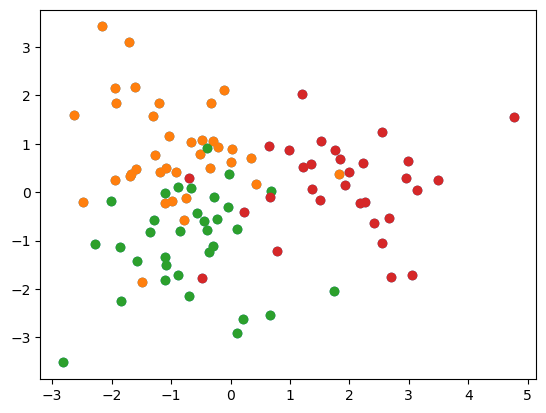

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_j = LinearDiscriminantAnalysis()
jvf = get_jv_feature_vectors(training_data)
lda_j.fit(jvf,ground_truth)
rjvf = lda_j.transform(jvf)
plt.scatter(rjvf[:,0],rjvf[:,1])
for dd in (low_data,moderate_data,high_data):
    ljvf = get_jv_feature_vectors(dd)
    rljvf = lda_j.transform(ljvf)
    plt.scatter(rljvf[:,0],rljvf[:,1])

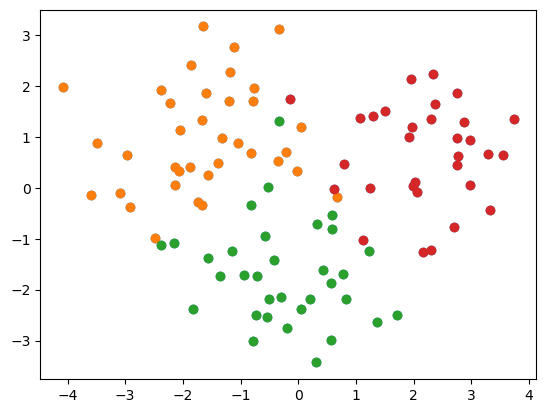

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_t = LinearDiscriminantAnalysis()
tvf = get_tv_feature_vectors(training_data)
lda_t.fit(tvf,ground_truth)
rtvf = lda_t.transform(tvf)
plt.scatter(rtvf[:,0],rtvf[:,1])
for dd in (low_data,moderate_data,high_data):
    ltvf = get_tv_feature_vectors(dd)
    rltvf = lda_t.transform(ltvf)
    plt.scatter(rltvf[:,0],rltvf[:,1])


In [15]:
def get_final_features(*features):
    return np.concatenate(features,axis=1)

# final_features = get_final_features(rjvf,rtvf)

In [16]:

def feature_maker(data):
    rjvf = lda_j.transform(get_jv_feature_vectors(df=data))
    rtvf = lda_t.transform(get_tv_feature_vectors(df=data))
    

    return get_final_features(rjvf,rtvf)
    

# Trainging Algorithms

In [17]:
final_training_features = feature_maker(training_data)

In [18]:
ss_linear = svm.SVC(kernel="linear")
evaluvate_algorithm_total(ss_linear,final_training_features,ground_truth)
_,_,ss_linear = evaluvate_algorithm_train_test(ss_linear,final_training_features,ground_truth)

***************Total data*****************
[[0.36 0.   0.  ]
 [0.02 0.31 0.  ]
 [0.01 0.02 0.28]]
0.9495154939222736
*********************************************
***************training data*****************
[[0.38571429 0.         0.        ]
 [0.         0.3        0.        ]
 [0.01428571 0.02857143 0.27142857]]
0.9543976348854398
*********************************************
***************testing data*****************
[[0.3        0.         0.        ]
 [0.06666667 0.33333333 0.        ]
 [0.         0.         0.3       ]]
0.9363636363636364
*********************************************


In [19]:
ss = svm.SVC()
evaluvate_algorithm_total(ss_linear,final_training_features,ground_truth)
_,_,ss = evaluvate_algorithm_train_test(ss_linear,final_training_features,ground_truth)

***************Total data*****************
[[0.36 0.   0.  ]
 [0.02 0.31 0.  ]
 [0.01 0.02 0.28]]
0.9495154939222736
*********************************************
***************training data*****************
[[0.35714286 0.         0.        ]
 [0.02857143 0.34285714 0.        ]
 [0.01428571 0.01428571 0.24285714]]
0.9430057138159246
*********************************************
***************testing data*****************
[[0.36666667 0.         0.        ]
 [0.         0.23333333 0.        ]
 [0.         0.03333333 0.36666667]]
0.9632850241545894
*********************************************


In [20]:
nn = MLPClassifier(hidden_layer_sizes=(100,100),alpha=1, max_iter=1000)
evaluvate_algorithm_total(nn,final_training_features,ground_truth)
_,_,nn = evaluvate_algorithm_train_test(nn,final_training_features,ground_truth)

***************Total data*****************
[[0.36 0.   0.  ]
 [0.   0.33 0.  ]
 [0.   0.   0.31]]
1.0
*********************************************
***************training data*****************
[[0.41428571 0.         0.        ]
 [0.         0.28571429 0.        ]
 [0.         0.         0.3       ]]
1.0
*********************************************
***************testing data*****************
[[0.23333333 0.         0.        ]
 [0.06666667 0.36666667 0.        ]
 [0.         0.03333333 0.3       ]]
0.9007894736842106
*********************************************


In [21]:
forest = RandomForestClassifier()
evaluvate_algorithm_total(forest,final_training_features,ground_truth)
_,_,forest = evaluvate_algorithm_train_test(forest,final_training_features,ground_truth)

***************Total data*****************
[[0.36 0.   0.  ]
 [0.   0.33 0.  ]
 [0.   0.   0.31]]
1.0
*********************************************
***************training data*****************
[[0.4        0.         0.        ]
 [0.         0.28571429 0.        ]
 [0.         0.         0.31428571]]
1.0
*********************************************
***************testing data*****************
[[0.26666667 0.         0.        ]
 [0.1        0.3        0.03333333]
 [0.03333333 0.         0.26666667]]
0.8356902356902357
*********************************************


In [22]:
knn = KNeighborsClassifier(n_neighbors=3)
evaluvate_algorithm_train_test(knn,final_training_features,ground_truth)
cm,score,knn = evaluvate_algorithm_total(knn,final_training_features,ground_truth)

***************training data*****************
[[0.34285714 0.         0.        ]
 [0.01428571 0.27142857 0.        ]
 [0.01428571 0.01428571 0.34285714]]
0.9566666666666667
*********************************************
***************testing data*****************
[[0.3        0.06666667 0.03333333]
 [0.         0.43333333 0.        ]
 [0.         0.03333333 0.13333333]]
0.8512315270935962
*********************************************
***************Total data*****************
[[0.35 0.   0.01]
 [0.01 0.32 0.  ]
 [0.01 0.02 0.28]]
0.9491537745064632
*********************************************


In [23]:
def predict(testing_data,algo,testing,test_feature_vectors):
    data = testing_data.copy()
    # data= training_data.head()
#     test_feature_vectors = lda.transform(get_jv_feature_vectors(df=data))
    profile_predictions =algo.predict(test_feature_vectors)
    copy_testing = testing.copy()
    copy_testing['shop_profile'] = list(map(iprofile_to_sprofile,profile_predictions,))
#     print(list(data['shop_id']),list(copy_testing['shop_id']))
    assert(list(data['shop_id']) == list(copy_testing['shop_id']))
#     data['profile']=copy_testing['shop_profile'].rename(index=lambda x : x+100)

    return copy_testing.copy()

# print(testing_data)

# test_rjvf = lda_j.transform(get_jv_feature_vectors(df=testing_data))
# test_rtvf = lda_t.transform(get_tv_feature_vectors(df=testing_data))

# test_feature_vectors = get_final_features(test_rjvf,test_rtvf)

test_feature_vectors = feature_maker(testing_data)

ss_predictions = predict(testing_data,ss,testing,test_feature_vectors)
ss_linear_predictions = predict(testing_data,ss_linear,testing,test_feature_vectors)
nn_predictions = predict(testing_data,nn,testing,test_feature_vectors)
knn_predictions = predict(testing_data,knn,testing,test_feature_vectors)
forest_predictions = predict(testing_data,forest,testing,test_feature_vectors)
# best_svm_predictions = predict(testing_data,best_svm,testing)


evaluvation_table = testing.copy().drop("shop_profile",axis=1)

evaluvation_table["svm"]=ss_predictions["shop_profile"]
evaluvation_table["nnl"]=nn_predictions["shop_profile"]
evaluvation_table["knn"]=knn_predictions["shop_profile"]
# evaluvation_table["forest"]=forest_predictions["shop_profile"]
evaluvation_table["ss_linear"]=ss_linear_predictions["shop_profile"]
# evaluvation_table["best_svm"]=best_svm_predictions["shop_profile"]

evaluvation_table

,shop_id,svm,nnl,knn,ss_linear
0,SHOP046,High,High,High,High
1,SHOP024,Moderate,Moderate,Moderate,Moderate
2,SHOP023,Low,Low,Low,Low
3,SHOP097,Moderate,Moderate,Moderate,Moderate
4,SHOP044,Moderate,Moderate,Moderate,Moderate
5,SHOP030,Moderate,Moderate,Low,Moderate
6,SHOP038,Moderate,Moderate,Moderate,Moderate
7,SHOP029,Low,Low,Low,Low
8,SHOP096,Low,Low,Low,Low
9,SHOP092,Moderate,Moderate,Moderate,Moderate


In [24]:
ss_predictions.to_csv("/kaggle/working/svm_predictions_juice.csv",index=False)
nn_predictions.to_csv("/kaggle/working/nn_predictions_juice.csv",index=False)